# Import stuff

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow import keras

# CNNs in Tensorflow
Typically:
- Input images are 3D (height, width, channels)
- A mini-batch is 4D (mini_batch_size, height, width, channels)
- The weights of a CNN is 4D (Fh, Fw, Fn, Fn)

# Basic CNN code

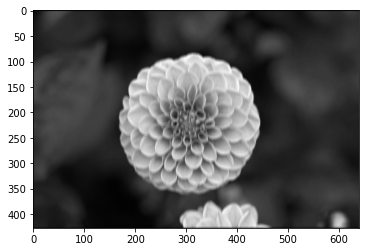

In [ ]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
inputs = np.array([china, flower])
batch_size, height, width, channels = inputs.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # Vertical
filters[3, :, :, 1] = 1 # Horizontal
outputs = tf.nn.conv2d(inputs, filters, strides=1, padding="SAME")
######### Normally we do not manually make filters, as we want them to be learnable by the model.

conv = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, # this creates a CNN layer with 32 filters with a size fo 3 x 3 with 0-padding.
                    padding="same", activation="relu")

plt.imshow(outputs[1, :, :, 0], cmap="gray") # Plot first image's first feature map
plt.show()
plt.imshow(outputs[1, :, :, 1], cmap="gray") # Plot first image's second feature map
plt.show()

# Pooling layers
- CNNs can get big real fast so pooling layers are used to shrink each layer's input image to reduce the computational load of each layer
- Has invariance meaning images with different translations have similar output images, in terms of their translations.
  - In MNIST digits, you could train the CNN to be invariant to digit boldness.
  - In drunk driving, CNN could learn to be invariant to hair color.
  ***^^^ only comes when in depth pooling***

Max Pooling
  - Works by shooting out a receptive field just like normal but only passes on the pixel with the greatest RGB inside that receptive field.

In [ ]:
# TF pooling layer
pooling_layer = tf.keras.layers.MaxPool2D(pool_size=2) # 2 x 2 kernel(receptive field); defaults are strides=kernel_size and padding is valid.

In [ ]:
# TF Depth pooling
depth_pooling = tf.nn.max_pool(inputs,
                               ksize=(1, 1, 1, 3),
                               strides=(1, 1, 1, 3),
                               padding="VALID")

# To include ^^^ as a layer, wrap in a Lambda function
depth_pool = tf.keras.layers.Lambda(lambda x: depth_pooling)

In [ ]:
# Global Average Pooling
gbl_avg_pooling = tf.keras.layers.GlobalAveragePooling2D()

# ^^^ same as
gbl_avg_pooling_iden = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=[1, 2]))

# MNIST CNN

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(64, 7, activation="relu",
                         padding="SAME", input_shape=[28, 28, 1]),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Conv2D(128, 3, activation="relu", padding="SAME") ,
  tf.keras.layers.Conv2D(128, 3, activation="relu", padding="SAME")  ,  
  tf.keras.layers.MaxPool2D(2) ,   
  tf.keras.layers.Conv2D(256, 3, activation="relu", padding="SAME") ,
  tf.keras.layers.Conv2D(256, 3, activation="relu", padding="SAME") ,   
  tf.keras.layers.MaxPool2D(2)  ,   
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dropout(0.5)           ,                                 
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10, activation="softmax")
])

#Architecture:
- Typically go like: Conv layers + a Relu + a Pool + Conv layers + a Relu + a Pool + . . . 
- Within the CNN, don't use big kernels like 5 x 5. Use 2 3 x 3 kernels and stack them.
  -***The first convolutional layer, however, is supposed to pretty big, like 5 x 5***

# Building a ResNet34(pg 330)

In [ ]:
class ResidualUnit(keras.layers.Layer):
  def __init__(self, filters, strides, activation="relu", **kwargs):
    super().__init__(**kwargs)
    self.activation = activation
    self.main_layers = [
      keras.layers.Conv2D(filters, 3, strides=strides,
                          padding="SAME", use_bias=False),
      keras.layers.BatchNormalization(),
      self.activation      ,                  
      keras.layers.Conv2D(filters, 3, strides=strides,
                          padding="SAME", use_bias=False),
      keras.layers.BatchNormalization()
    ]
    skip_layers = []
    if strides > 1:
      skip_layers = [
        keras.layers.Conv2D(filters, 1, strides=strides,
                          padding="SAME", use_bias=False),
      keras.layers.BatchNormalization()                     
      ]

  def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
    skip_Z = inputs
    for layer in self.skip_layers:
      skip_Z = layer(skip_Z)
    return self.activation(skip_Z + Z)

In [ ]:
model = keras.Sequential()
keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224, 3],
                      padding = "SAME", use_bias=False)
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters=64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  strides=1 if filters==prev_filters else 2
  model.add(ResidualUnit(filters, strides=strides))
  prev_filters = filters
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

# Using a built-in keras resnet50(pg 335)

# Transfer learning with CNNs using the XInception Model

## Get data prepped

In [ ]:
import tensorflow_datasets as tfds 
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
print(info, "\n")
class_names = info.features["label"].names
print(class_names, "\n")
n_classes = len(class_names)
n_classes

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)
 

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'] 



5

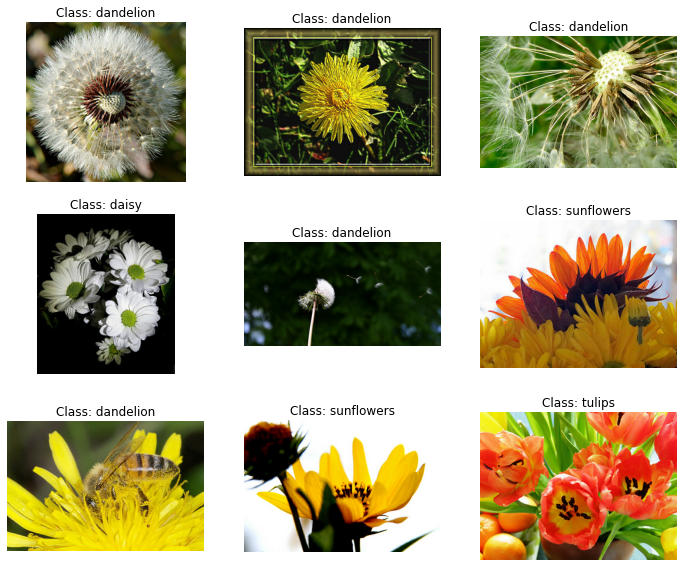

In [ ]:
# Dataset isn't split yet so split it
test_split, valid_split, train_split = tfds.load(
    "tf_flowers",
    split=[
          "train[:10%]",
          "train[10%:25%]",
          "train[25%:]"
    ],
    as_supervised=True
)

plt.figure(figsize=(12, 10))
index = 0
for image, label in train_split.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [ ]:
# Resizing the thing
def preprocess(image, label): 
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

# Making actual sets now
batch_size = 32
train_set = train_split.shuffle(1000).repeat()
train_set = train_split.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_split.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_split.map(preprocess).batch(batch_size).prefetch(1)    
train_set

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

## Get the Xception model

In [ ]:
base_model = tf.keras.applications.xception.Xception(include_top=False, weights="imagenet")
# include_top=False means that we are not going to use the top 2 layers of the original Xception model

avg_pool = tf.keras.layers.GlobalAveragePooling2D()(base_model.output) # Make our own pools.
                                                                       # Here you shove in Xceptions current outputs(doesn't have top layers tho, we making those)
outputs = tf.keras.layers.Dense(n_classes, activation="softmax")(avg_pool)
model = tf.keras.Model(inputs=base_model.inputs, outputs=outputs)

for layer in base_model.layers:
  layer.trainable = False # It's a good thing to freeze the weights and stuff of the reused models.

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/5
86/86 [==============================] - 28s 158ms/step - loss: 1.5180 - accuracy: 0.7860 - val_loss: 1.2225 - val_accuracy: 0.8330
Epoch 2/5
86/86 [==============================] - 13s 146ms/step - loss: 0.5657 - accuracy: 0.9088 - val_loss: 0.9214 - val_accuracy: 0.8621
Epoch 3/5
86/86 [==============================] - 13s 147ms/step - loss: 0.2307 - accuracy: 0.9444 - val_loss: 0.7328 - val_accuracy: 0.8730
Epoch 4/5
86/86 [==============================] - 13s 148ms/step - loss: 0.1184 - accuracy: 0.9673 - val_loss: 0.6806 - val_accuracy: 0.8711
Epoch 5/5
86/86 [==============================] - 13s 150ms/step - loss: 0.0830 - accuracy: 0.9757 - val_loss: 0.6890 - val_accuracy: 0.8675


In [ ]:
model.evaluate(test_set)

12/12 [==============================] - 2s 184ms/step - loss: 0.6339 - accuracy: 0.8801


[0.6339281797409058, 0.8801090121269226]

## Trying unfreezing layers
- When you unfreeze pretrained layers, lower the lr so it doesn't mess the reused layers up

In [ ]:
for layer in base_model.layers:
  layer.trainable=True

optimizer = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, epochs=40, validation_data=valid_set) 

In [ ]:
model.evaluate(test_set)

12/12 [==============================] - 2s 121ms/step - loss: 0.3279 - accuracy: 0.9292


[0.32786089181900024, 0.9291552901268005]

# CNN Notes
- A layer in a CNN is 2D which is why CNNs are extremely good for images
- Each neuron in a CNN is connected to only a certain batch of neurons in the next layer => Receptive Field.
  - A neuron at (i, j) in one layer is connected to a neuron in the previous layer at (i + fh - 1, j + fw - 1) for some receptive field with a width of fw and height fh.
- Put zeroes around inputs (padding) when the receptive field goes beyond the layer size(if a neuron is on the edge of a layer, its receptive field would go beyond the size of the next layer).
- CNNs have a mixture of filters to look at specific things. For example, a filter might only look horizontally, creating a horizontal feature map, while another might look vertically, creating a vertical feature map(whichever activates the CNN most).
- All neurons in the same feature map share the same parameters so the CNN can identify the characteristics everywhere unlike a DNN.
- To	convert	a	dense	layer	to	a	convolutional	layer,	the	number	of	filters	in	the	convolutional	layer	must	be	equal to	the	number	of	units	in	the	dense	layer,	the	filter	size	must	be	equal	to	the	size	of	the	input	feature	maps,	and you	must	use		padding.	The	stride	may	be	set	to	1	or	more,	as	we	will	see	shortly

https://jhui.github.io/2017/03/16/CNN-Convolutional-neural-network/

